In [431]:
# Cloning repository with the data for the experiment
# data -> thermalImagesClassificatoin/data/ ...

!git clone https://github.com/rgmantovani/thermalImagesClassification.git

fatal: destination path 'thermalImagesClassification' already exists and is not an empty directory.


In [432]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2 #opencv in pyhton
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [433]:
# For help: https://github.com/ribeiro-julio/crop-image-classification/blob/main/scripts/04_running_CNN.py

from tensorflow.keras import layers, models
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint

from tensorflow.keras.applications import VGG19, ResNet50

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [434]:
# For data augmentation
import albumentations as A

In [435]:
# ----------------------------
# ----------------------------

# constant for experiment
num_classes = 2

# TYPE_OF_IMAGE = "raw"
TYPE_OF_IMAGE = "rgb"

# MODEL = "cnn"
# MODEL = "vgg19"
MODEL = "lwcnn2"
#MODEL = "resnet"

DATA_AUGMENTATION = True
# DATA_AUGMENTATION = False

# ----------------------------
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
# ----------------------------

SEEDS = [171, 666, 42, 51, 404, 720, 269, 289, 376, 767]
SEEDS.sort()
current_seed = SEEDS[9]
print("Seed: ", current_seed)

keras.utils.set_random_seed(current_seed)

Seed:  767


In [436]:
# data directory
health_dir = "/content/thermalImagesClassification/data/saudaveis"
osteo_dir  = "/content/thermalImagesClassification/data/diagnosticos"

In [437]:
# loading filepaths
csv_files_health = glob.glob(os.path.join(health_dir, "**","*.csv"),recursive=True)
csv_files_osteo  = glob.glob(os.path.join(osteo_dir, "**", "*.csv"),recursive=True)

In [438]:
raw_file = csv_files_health[0]
print(raw_file)

/content/thermalImagesClassification/data/saudaveis/tibia_em_pe/Em_pe_51.csv


In [439]:
# ----------------------------------------------------------------------------
# Creating labels
# ----------------------------------------------------------------------------
Y_healthy = np.zeros(len(csv_files_health))
Y_osteo  = np.ones(len(csv_files_osteo))

# concatenating values
Y = np.concatenate((Y_healthy, Y_osteo))

# ----------------------------------------------------------------------------
# ----------------------------------------------------------------------------

In [440]:
# --------------------------------------------------------------
# Splitting files into training and testing folds
# --------------------------------------------------------------
all_files = csv_files_health + csv_files_osteo

x_train_files, x_test_files, y_train, y_test = train_test_split(all_files,
    Y, test_size=0.3, random_state=42, stratify=Y)

In [441]:
print("Tamanho do X_train:", len(x_train_files))
print("Tamanho do X_test:", len(x_test_files))
print("Tamanho do y_train:", y_train.shape)
print("Tamanho do y_test:", y_test.shape)

Tamanho do X_train: 511
Tamanho do X_test: 220
Tamanho do y_train: (511,)
Tamanho do y_test: (220,)


In [442]:
# --------------------------------------------------------------
# function to plot thermal imagens from raw file
# --------------------------------------------------------------

def plot_csv_image(csv_file):
    data = pd.read_csv(csv_file, header=None)
    image_array = data.to_numpy()
    plt.imshow(image_array, cmap='inferno', interpolation='nearest')
    plt.colorbar()
    plt.show()


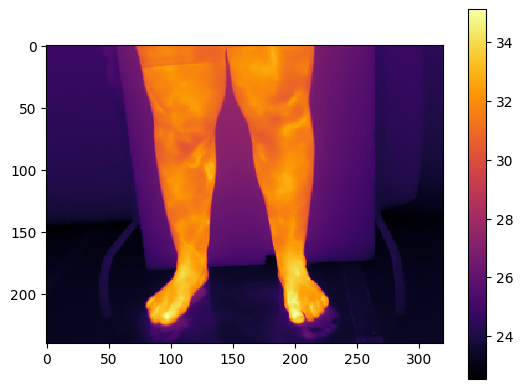

/content/thermalImagesClassification/data/saudaveis/tibia_em_pe/Em_pe_196.csv
0.0


In [443]:
plot_csv_image(csv_file=x_train_files[0])
# plot_csv_image(csv_file=x_test_files[0])
print(x_test_files[0])
print(y_test[0])

In [444]:
# --------------------------------------------------------------
# function to load thermal images from csv files
# --------------------------------------------------------------

def load_images_from_csv_files(csv_files):
  if not csv_files:
    raise Exception("No *.csv file was found.")

  raw_images = [pd.read_csv(file).to_numpy() for file in csv_files]
  return(raw_images)


In [445]:
# --------------------------------------------------------------
# reading images from files
# --------------------------------------------------------------

x_train_images = load_images_from_csv_files(csv_files=x_train_files)
print(x_train_images[0].shape)

x_test_images = load_images_from_csv_files(csv_files=x_test_files)
print(x_test_images[0].shape)


(239, 320)
(239, 320)


In [446]:
df = pd.DataFrame(x_train_images[0])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,310,311,312,313,314,315,316,317,318,319
0,24.95610,24.95068,24.94526,24.94526,24.94526,24.93983,24.93983,24.93983,24.94526,24.94526,...,24.44527,24.45072,24.45072,24.46162,24.45617,24.45617,24.46162,24.46162,24.46706,24.46162
1,24.96152,24.95610,24.95610,24.95610,24.95068,24.95068,24.93983,24.93983,24.93983,24.93983,...,24.43983,24.44527,24.45072,24.44527,24.45072,24.45072,24.46162,24.46162,24.46162,24.46162
2,24.95068,24.95610,24.95068,24.94526,24.95068,24.94526,24.93983,24.93983,24.93441,24.93441,...,24.43438,24.43438,24.44527,24.43983,24.44527,24.45072,24.45072,24.46162,24.45617,24.46162
3,24.94526,24.94526,24.94526,24.93983,24.93983,24.93983,24.93441,24.92899,24.92357,24.92899,...,24.42893,24.42893,24.43438,24.43438,24.43983,24.44527,24.44527,24.45072,24.45072,24.45072
4,24.93441,24.93983,24.93441,24.93441,24.92899,24.92357,24.91814,24.91814,24.91272,24.91272,...,24.41803,24.42348,24.42893,24.42893,24.43438,24.43438,24.43983,24.44527,24.45072,24.44527


In [447]:
# Min and Max temperature values in the raw image
selected_id = 50
print("Image: ", x_train_files[selected_id])
print("Min value: ", np.min(x_train_images[selected_id]))
print("Max value: ", np.max(x_train_images[selected_id]))
print("Mean: ", np.mean(x_train_images[selected_id]))

Image:  /content/thermalImagesClassification/data/diagnosticos/fraturas_osseas/fratura_de_tibia_fibula_ilizarov/pessoa03/pessoa03_avaliacao02.csv
Min value:  24.34586
Max value:  34.28085
Mean:  28.952221667625526


In [448]:
# --------------------------------------------------------------
# normalize image withing [min, max] range
# --------------------------------------------------------------

def normalize(image):
    max = np.amax(image)
    min = np.amin(image)
    normalized_image = (image-min)/(max - min)
    return (normalized_image)

In [449]:
# -----------------------------------------------
# -----------------------------------------------

def thermal_to_rgb_image(image):
  norm_img = normalize(image = image)
  new_img  = np.round(norm_img * 255)
  u8 = new_img.astype(np.uint8)
  im_color = cv2.applyColorMap(u8, cv2.COLORMAP_JET)
  return(im_color)

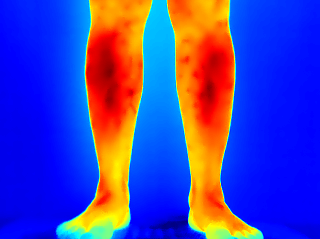

In [450]:
# example of RGB healthy image
imgc = thermal_to_rgb_image(image = x_train_images[2])
cv2_imshow(imgc)

In [451]:
imgc.shape

(239, 320, 3)

In [452]:
# converting all healthy thermal raw images to RGB

if(TYPE_OF_IMAGE == "rgb"):
  print("* Converting thermal images to RGB")
  new_x_train_images = [thermal_to_rgb_image(x) for x in x_train_images]
  new_x_test_images  = [thermal_to_rgb_image(x) for x in x_test_images]
  input_shape = (239, 320, 3)
else:
  print ("* Using raw images - normalized between [0, 1]")
  new_x_train_images = [normalize(x) for x in x_train_images]
  new_x_test_images  = [normalize(x) for x in x_test_images]
  input_shape = (239, 320, 1)

* Converting thermal images to RGB


In [453]:
# -------------------------------------------
# Creating Training Dataset
# -------------------------------------------
X_train = np.array(new_x_train_images)
X_test  = np.array(new_x_test_images)

In [454]:
# convert values to the inverval [0, 1]
if(TYPE_OF_IMAGE != "raw"):
  X_train = X_train.astype("float32") / 255
  X_test = X_test.astype("float32") / 255

<Axes: ylabel='Frequency'>

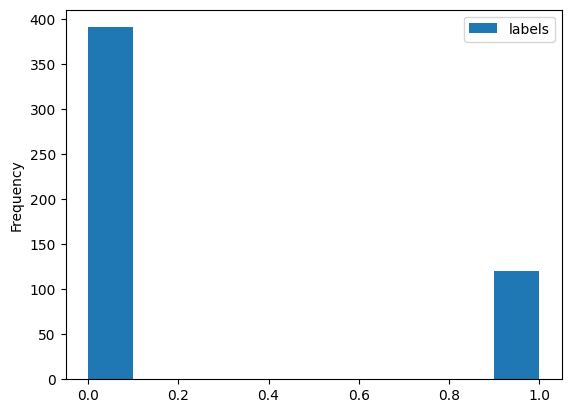

In [455]:
df_y_train = pd.DataFrame(y_train)
df_y_train.columns = ['labels']
df_y_train.plot.hist()

In [456]:
print(len(y_train[y_train == 1]))
print(len(y_train[y_train == 0]))

120
391


In [457]:
# ------------------------------------------------------------
# ------------------------------------------------------------

# Data augmentation da classe minoritaria (quais operacoes)
# usar data augmentation -> https://albumentations.ai/

# ------------------------------------------------------------
# ------------------------------------------------------------

def apply_aug(image, transform):
    augmented = transform(image=image)
    return augmented["image"]

def dataAugmentation(X_train, y_train):
  #link com outras transformações caso queria dar uma olhada: https://explore.albumentations.ai/
  augmentations = [
      A.HorizontalFlip(p=1.0),
      A.VerticalFlip(p=1.0)
      # A.AdditiveNoise(p=1.0)
  ]

  X_min = X_train[y_train == 1]
  y_min = y_train[y_train == 1]

  augmented_images = []
  augmented_labels = []

  for img in X_min:
      for transform in augmentations:
          aug_img = apply_aug(img, transform)
          augmented_images.append(aug_img)
          augmented_labels.append(1)

  X_augmented = np.array(augmented_images)
  y_augmented = np.array(augmented_labels)

  X_train_balanced = np.concatenate((X_train, X_augmented), axis=0)
  y_train_balanced = np.concatenate((y_train, y_augmented), axis=0)

  print(f'Depois do augmentation: {X_train_balanced.shape}')
  return(X_train_balanced, y_train_balanced)

In [458]:
if DATA_AUGMENTATION:

  print(f'Antes do augmentation: {X_train.shape}')
  X_train, y_train = dataAugmentation(X_train, y_train)
  print(f'Depois do augmentation: {X_train.shape}')

  # output files
  history_file = f"log_history_{MODEL}_DA_{TYPE_OF_IMAGE}_seed_{current_seed}.csv"
  model_file   = f"best_model_{MODEL}_DA_{TYPE_OF_IMAGE}_seed_{current_seed}.keras"
  performance_file = f"performances_{MODEL}_DA_{TYPE_OF_IMAGE}_seed_{current_seed}.csv"
  predictions_file = f"predictions_{MODEL}_DA_{TYPE_OF_IMAGE}_seed_{current_seed}.csv"

else:
  model_file   = f"best_model_{MODEL}_{TYPE_OF_IMAGE}_seed_{current_seed}.keras"
  history_file = f"log_history_{MODEL}_{TYPE_OF_IMAGE}_seed_{current_seed}.csv"
  predictions_file = f"predictions_{MODEL}_{TYPE_OF_IMAGE}_seed_{current_seed}.csv"
  performance_file = f"performances_{MODEL}_{TYPE_OF_IMAGE}_seed_{current_seed}.csv"

Antes do augmentation: (511, 239, 320, 3)
Depois do augmentation: (751, 239, 320, 3)
Depois do augmentation: (751, 239, 320, 3)


<Axes: ylabel='Frequency'>

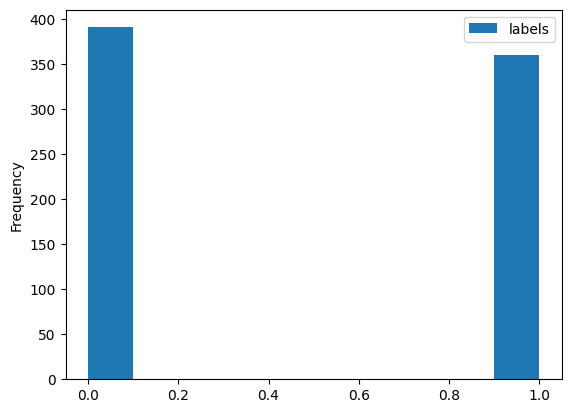

In [459]:
df_y_train = pd.DataFrame(y_train)
df_y_train.columns = ['labels']
df_y_train.plot.hist()

In [460]:
# Classical CNN architecture
def get_CNN_model(input_shape):

	CNNmodel = models.Sequential()
	CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
	CNNmodel.add(layers.MaxPooling2D((2, 2)))
	CNNmodel.add(layers.Dropout(0.25))
	CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
	CNNmodel.add(layers.MaxPooling2D((2, 2)))
	CNNmodel.add(layers.Dropout(0.25))
	CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
	CNNmodel.add(layers.Flatten())
	CNNmodel.add(layers.Dense(64, activation='relu'))
	CNNmodel.add(layers.Dropout(0.5))
	CNNmodel.add(layers.Dense(1, activation="sigmoid"))

	return(CNNmodel)

In [461]:
def get_VGG19_model_Keras(input_shape) :

  VGGmodel = models.Sequential()
  baseModel = VGG19(input_shape=input_shape, weights='imagenet',include_top=False)
  baseModel.trainable = False
  VGGmodel.add(baseModel)
  VGGmodel.add(layers.Flatten())
  VGGmodel.add(layers.Dense(4096,activation = 'relu'))
  VGGmodel.add(layers.Dense(4096,activation = 'relu'))
  VGGmodel.add(layers.Dense(1,activation = 'sigmoid'))
  return(VGGmodel)

In [462]:
# Light weight convolutional neural network and low-dimensional images transformation approach for classification of thermal images
# https://www.sciencedirect.com/science/article/pii/S2214157X22009078

def get_LW_CNN_model_Taspinar(input_shape):

  LWCNN_model = models.Sequential()
  LWCNN_model.add(layers.Conv2D(6, (5, 5), input_shape=input_shape))
  LWCNN_model.add(layers.LeakyReLU(alpha=0.01))
  LWCNN_model.add(layers.MaxPooling2D((2, 2)))

  LWCNN_model.add(layers.Conv2D(16, (5, 5)))
  LWCNN_model.add(layers.LeakyReLU(alpha=0.01))
  LWCNN_model.add(layers.MaxPooling2D((2, 2)))

  LWCNN_model.add(layers.Conv2D(64, (3, 3)))
  LWCNN_model.add(layers.LeakyReLU(alpha=0.01))
  LWCNN_model.add(layers.MaxPooling2D((2, 2)))

  LWCNN_model.add(layers.Flatten())
  LWCNN_model.add(layers.Dense(128))
  LWCNN_model.add(layers.LeakyReLU(alpha=0.01))

  LWCNN_model.add(layers.Dropout(0.2))
  LWCNN_model.add(layers.Dense(1, activation="sigmoid"))

  return(LWCNN_model)

In [463]:
def get_ResNet50_model_Keras(input_shape) :

  ResNetmodel = models.Sequential()
  baseModel = ResNet50(input_shape=input_shape, weights='imagenet',include_top=False)
  baseModel.trainable = True
  ResNetmodel.add(baseModel)
  ResNetmodel.add(layers.GlobalAveragePooling2D())
  ResNetmodel.add(layers.Dropout(0.5))
  ResNetmodel.add(layers.Dense(128, activation='relu'))
  ResNetmodel.add(layers.Dense(2,activation = 'softmax'))

  return(ResNetmodel)

In [464]:
# Classical CNN architecture

def get_LWCNN_Zeh(input_shape):
	CNNmodel = models.Sequential()
	CNNmodel.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=input_shape))
	CNNmodel.add(layers.MaxPooling2D((2, 2)))
	CNNmodel.add(layers.Dropout(0.25))
	CNNmodel.add(layers.Conv2D(8, (3, 3), activation='relu'))
	CNNmodel.add(layers.MaxPooling2D((2, 2)))
	CNNmodel.add(layers.Dropout(0.25))
	CNNmodel.add(layers.Conv2D(16, (3, 3), activation='relu'))
	CNNmodel.add(layers.Flatten())
	CNNmodel.add(layers.Dense(64, activation='relu'))
	CNNmodel.add(layers.Dropout(0.5))
	CNNmodel.add(layers.Dense(32, activation='relu'))
	CNNmodel.add(layers.Dropout(0.5))
	CNNmodel.add(layers.Dense(1, activation="sigmoid"))

	return(CNNmodel)

In [465]:
# Defining DL model
match MODEL:
  case "cnn":
    model = get_CNN_model(input_shape=input_shape)
  case "vgg19":
    model = get_VGG19_model_Keras(input_shape=input_shape)
  case "lwcnn":
    model = get_LW_CNN_model_Taspinar(input_shape=input_shape)
  case "resnet":
    model = get_ResNet50_model_Keras(input_shape=input_shape)
  case "lwcnn2":
    model = get_LWCNN_Zeh(input_shape=input_shape)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 237, 318, 4)    │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 118, 159, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 118, 159, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 116, 157, 8)    │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 58, 78, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 58, 78, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 56, 76, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 68096)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │     4,358,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,361,897 (16.64 MB)

 Trainable params: 4,361,897 (16.64 MB)

 Non-trainable params: 0 (0.00 B)

In [466]:
if MODEL == "resnet":
  model.compile(optimizer='adam', loss=CategoricalCrossentropy(),
      metrics=['binary_accuracy', 'accuracy', 'precision', 'recall', 'AUC'])
  y_train = keras.utils.to_categorical(y_train, 2)
  y_test  = keras.utils.to_categorical(y_test, 2)
else:
  model.compile(optimizer='adam', loss=BinaryCrossentropy(),
      metrics=['binary_accuracy', 'accuracy', 'precision', 'recall', 'AUC'])

In [467]:
 # Callbacks
model_checkpoint = ModelCheckpoint(filepath=model_file, monitor='val_loss',
                                   save_best_only=True,mode='min', verbose=1)

early_stopper = EarlyStopping(monitor="val_loss", mode="min", patience=10,
                                verbose=1, restore_best_weights=True)

csv_logger    = CSVLogger(filename=history_file, separator=",", append=False)

In [425]:
# ----------------------------
# Traninig the algorithm
# ----------------------------

print(f" - training {MODEL}\n")

history  = model.fit(X_train, y_train, epochs=100, validation_split=0.3, batch_size=16,
                         callbacks=[csv_logger, model_checkpoint, early_stopper], shuffle=True)

 - training lwcnn2

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - AUC: 0.4781 - accuracy: 0.5598 - binary_accuracy: 0.5598 - loss: 0.7925 - precision: 0.2505 - recall: 0.3444
Epoch 1: val_loss improved from inf to 1.08272, saving model to best_model_lwcnn2_DA_rgb_seed_767.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - AUC: 0.4797 - accuracy: 0.5623 - binary_accuracy: 0.5623 - loss: 0.7892 - precision: 0.2513 - recall: 0.3415 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 1.0827 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.7336 - accuracy: 0.7637 - binary_accuracy: 0.7637 - loss: 0.5006 - precision: 0.6704 - recall: 0.1758
Epoch 2: val_loss improved from 1.08272 to 0.87730, saving model to best_model_lwcnn2_DA_rgb_seed_767.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 0.7344 - accuracy: 0.7635 - binary_accuracy: 0.7635 - loss: 0.5000 - precision: 0.6662

In [426]:
# ----------------------------
# Evaluating predictions
# ----------------------------
print(" - Evaluating DL model")
predictions = model.predict(X_test)

if(MODEL == "resnet"):
  rounded_predictions = np.argmax(predictions, axis=1)
  y_test = np.argmax(y_test, axis=1)
else:
  rounded_predictions = np.round(predictions)

# print(rounded_predictions)

 - Evaluating DL model
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


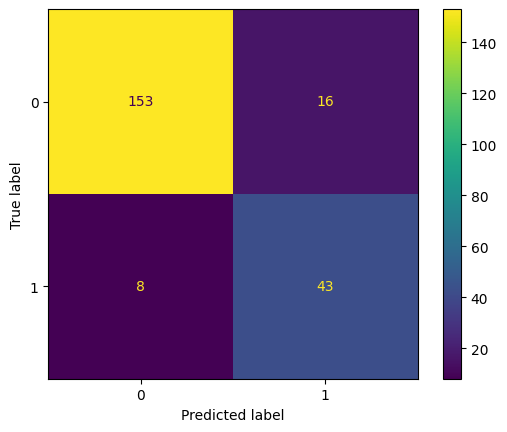

In [427]:
cm = confusion_matrix(y_test, rounded_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [428]:
# ----------------------------
# evaluating with scikit learn metrics
# ----------------------------
acc = accuracy_score(y_test, rounded_predictions)
bac = balanced_accuracy_score(y_test, rounded_predictions)
f1s = f1_score(y_test, rounded_predictions)
print("----------------------------")
print("acc = ", acc)
print("bac = ", bac)
print("f1c = ", f1s)
print("----------------------------")

performances = ([acc, bac, f1s, current_seed, TYPE_OF_IMAGE, MODEL])
print(performances)
df_performances = pd.DataFrame(performances).transpose()
df_performances.columns = ['accuracy', 'balanced_accuracy', 'fscore', 'seed', 'type_of_image', 'model']
df_performances.to_csv(performance_file, index = False)
df_performances.head()

----------------------------
acc =  0.8909090909090909
bac =  0.8742313493444716
f1c =  0.7818181818181819
----------------------------
[0.8909090909090909, np.float64(0.8742313493444716), 0.7818181818181819, 767, 'rgb', 'lwcnn2']


,accuracy,balanced_accuracy,fscore,seed,type_of_image,model
0,0.890909,0.874231,0.781818,767,rgb,lwcnn2


In [429]:
# -----------------------------------------------------------
# adding predictions to a data frame
# -----------------------------------------------------------

df_x_test_files = pd.DataFrame(x_test_files)
df_pred  = pd.DataFrame(rounded_predictions)
df_label = pd.DataFrame(y_test)
df_merged = pd.concat([df_x_test_files, df_pred, df_label], axis = 1)
df_merged.columns = ['filepath', 'predictions', 'labels']
df_merged.to_csv(predictions_file, index = False)
df_merged.head()

# -----------------------------------------------------------
# -----------------------------------------------------------

,filepath,predictions,labels
0,/content/thermalImagesClassification/data/saud...,0.0,0.0
1,/content/thermalImagesClassification/data/saud...,0.0,0.0
2,/content/thermalImagesClassification/data/saud...,0.0,0.0
3,/content/thermalImagesClassification/data/saud...,0.0,0.0
4,/content/thermalImagesClassification/data/diag...,1.0,1.0


In [430]:
print("Finished !!! :) ")

Finished !!! :) 
